<a href="https://colab.research.google.com/github/cusiandrea/datascienceportfolio/blob/main/Transfer_learning_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning - Image classification

A practical example of transfer learning, applied to image classification.

The goal is to train a deep learning model in order to classify images as *food* or *not*, with a limited number of images available.

Transfer learning is often used to solve problems with limited data. This is because deep learning models typically require a large amount of data to train, which can be difficult or expensive to obtain.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
from tensorflow.keras.applications import resnet50,ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

## DATA

In order to read the given images, an *ImageDataGenerator* is set up, with ResNet50 preprocessing function. As mentioned later in the notebook, ResNet50 is used as base model. Therefore it generates images with the specific size of 224x224, suitable for Resnet50.

The generator is defined for both training and validation set.

The dataset is perfectly balanced between *food* and *not food*.

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Dataset/Food_or_not_food/train/',
                                                    target_size = (224, 224),
                                                    batch_size = 32,
                                                    shuffle = False)

Found 100 images belonging to 2 classes.


In [4]:
val_datagen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

val_generator = val_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Dataset/Food_or_not_food/val/',
                                                  target_size = (224, 224),
                                                  batch_size = 32,
                                                  shuffle = False)

Found 20 images belonging to 2 classes.


## MODEL

In order to build the model, the pre-trained model **ResNet50** is loaded, without its top layers. On top of the base model, new and customized layers are added in order to **fine-tune** the model to the desidered task: a binary classification (*food* vs *not food*)

In [8]:
base_model = ResNet50(weights='imagenet', include_top = False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu',name='my_layer_1')(x)
x = Dense(512, activation='relu',name='my_layer_2')(x)
preds = Dense(2, activation ='softmax', name='my_layer_3')(x)

transfer_model = Model(inputs=base_model.input, outputs=preds)

The ResNet50 174 layers used as base are already trained, therefore they are preserved during training, while the added layers will be trained.

In [9]:
for layer in transfer_model.layers[:175]:
    layer.trainable = False
for layer in transfer_model.layers[175:]:
    layer.trainable = True

In [20]:
transfer_model.compile(optimizer='Adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [21]:
callback_es = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=2, verbose=1, restore_best_weights=True, start_from_epoch=5)

In [22]:
history = transfer_model.fit(train_generator,
                             validation_data=val_generator,
                             epochs = 10,
                             callbacks = [callback_es])

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6349 - loss: 1.8771 - val_accuracy: 0.7500 - val_loss: 1.4195
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.9500 - val_loss: 0.0629
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9908 - loss: 0.0327 - val_accuracy: 0.9500 - val_loss: 0.1549
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0112 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 4.8175e-04 - val_accuracy: 1.0000 - val_loss: 0.0096
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 1.0000 - loss: 1.7773e-05 - val_accuracy: 1.0000 - val_loss: 5.8590e-04
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 4.3500e-06 - val_accuracy: 1.00

In [23]:
transfer_model.evaluate(val_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 1.0000 - loss: 0.0022


[0.0021977985743433237, 1.0]

The model has exeptional performance in both training and validation sets, reaching 100% of accuracy.

## TESTING THE MODEL

A similar generator is set up for the test set. For a more convenient image visualization in later steps, the generator loads the images in *x_test_raw* with no preprocessing. The preprocessed images are saved in *x_test* instead.

In [ ]:
test_raw_datagen = ImageDataGenerator()
x_test_raw, y_test = next(test_raw_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Dataset/Food_or_not_food/test/',
                                                                target_size = (224, 224),
                                                                batch_size = 20,
                                                                shuffle = True))
x_test = resnet50.preprocess_input(x_test_raw)

Found 20 images belonging to 2 classes.


An example of test set image

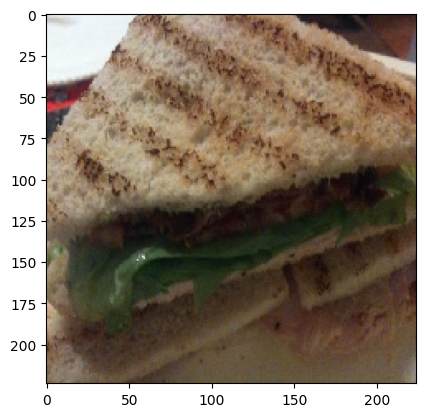

In [ ]:
plt.imshow(array_to_img(x_test_raw[0]));

In [ ]:
transfer_model.evaluate(x_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.0941


[0.09408394992351532, 1.0]

The model **perfectly** classified the 20 test images.

The test set images are then printed with the model prediction, in green color if correct and red if incorrect.

In [ ]:
preds = transfer_model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [ ]:
preds_labels = list(np.argmax(preds, axis=1))
preds_labels = ['Food' if x == 0 else 'Not Food' for x in preds_labels]

In [ ]:
true_labels = list(np.argmax(y_test, axis=1))
true_labels = ['Food' if x == 0 else 'Not Food' for x in true_labels]

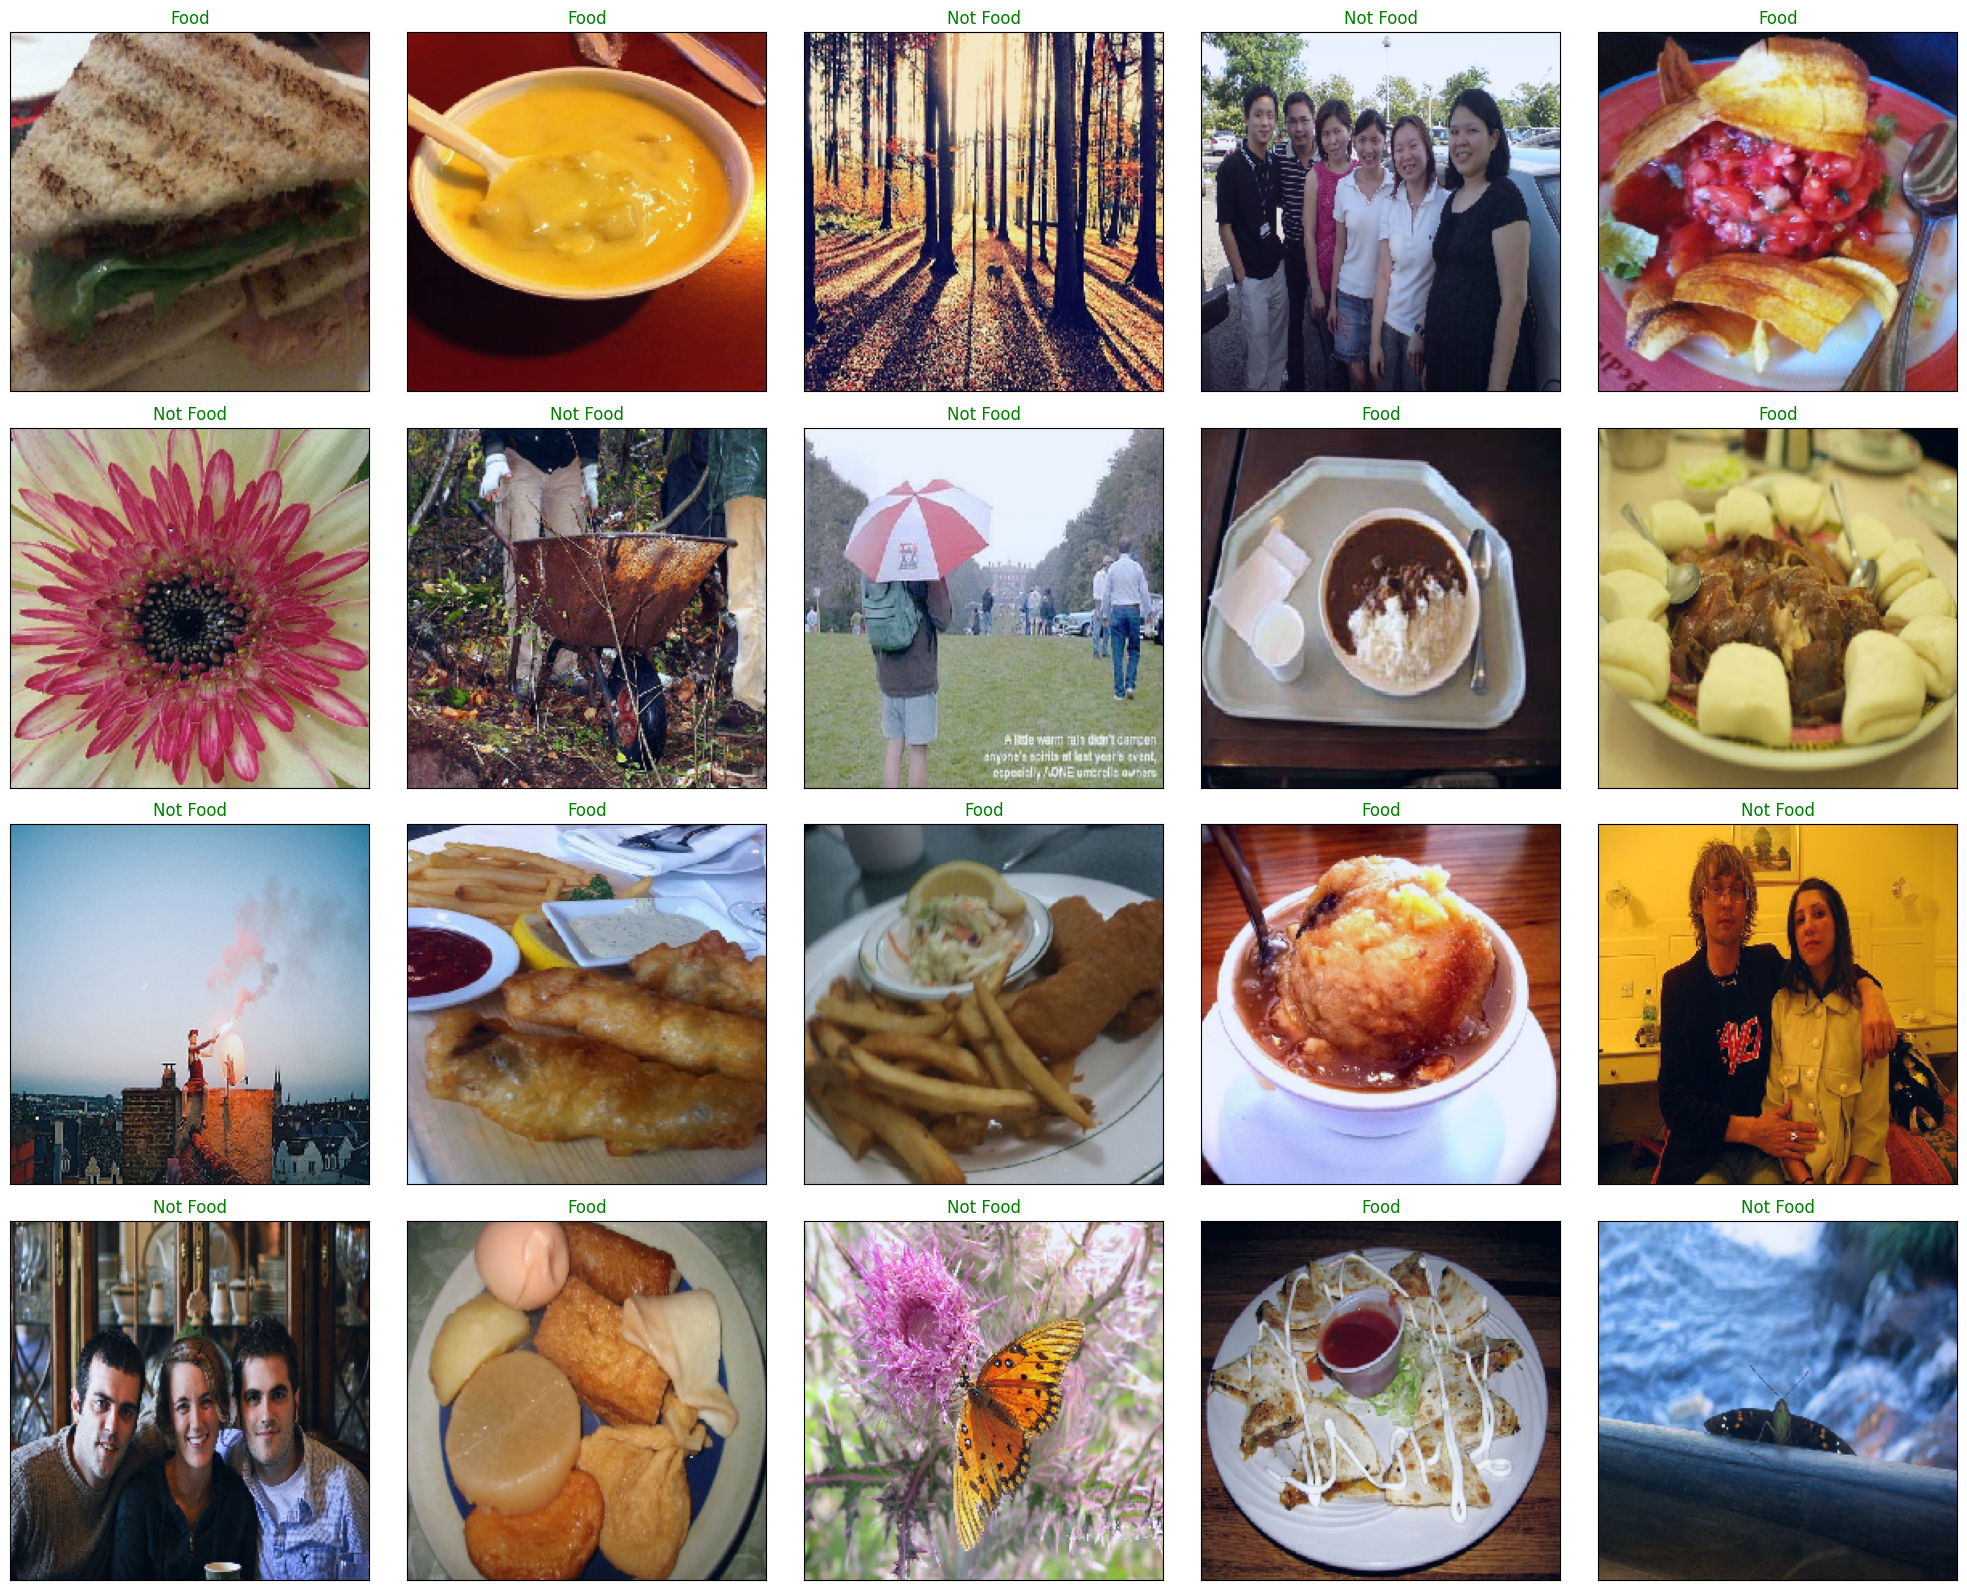

In [ ]:
plt.figure(figsize=(20,16))
for k in range(20):
    plt.subplot(4,5,k+1)
    plt.imshow(array_to_img(x_test_raw[k]))
    plt.title(preds_labels[k], color='green' if true_labels[k]==preds_labels[k] else 'red')
    plt.xticks([],[])
    plt.yticks([],[])
plt.tight_layout();